**Coding Resources**
- https://github.com/lestercardoz11/SP-500-index-anomaly-detection - (S&P 500 anomaly detection repository)
- https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/ - (S&P 500 anomaly detection tutorial)
- https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/ - (pytorch LSTM implementation tutorial)
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ - (pytorch LSTM implementation tutorial, more relevant)

In [31]:
import torch.nn as nn
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import optim
from torch.utils import data
import os
import torch.nn.functional as F

**S&P 500 Daily Prices 1986-2018**

In [32]:
filepath = './data/spx.csv'
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(8192, 2)


,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


**Visualize Data**

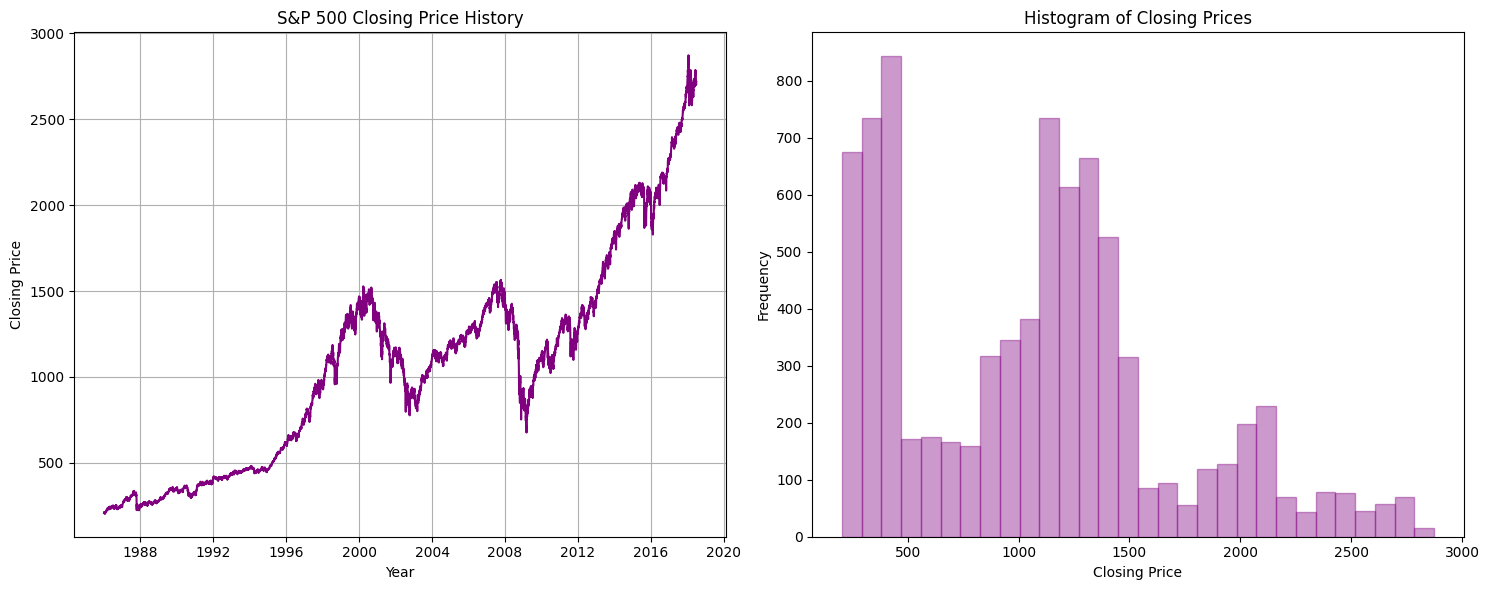

In [33]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# plot time series data
ax1.plot(df['date'], df['close'], color='purple')
ax1.set_xlabel('Year')
ax1.set_ylabel('Closing Price')
ax1.set_title('S&P 500 Closing Price History')
ax1.grid(True)

# plot histogram
ax2.hist(df['close'], bins=30, color='purple', edgecolor='purple', alpha=0.4, histtype='bar')
ax2.set_title('Histogram of Closing Prices')
ax2.set_xlabel('Closing Price')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Split & Standardize Data**

In [34]:
# split dataset (85% training, 10% validation, 5% testing)
train_df, test_df = train_test_split(df, test_size=0.05, shuffle=False)
train_df, valid_df = train_test_split(train_df, test_size=0.1, shuffle=False)

print("Train Dataframe:", train_df.shape)
print("Val Dataframe:", valid_df.shape)
print("Test Dataframe: ", test_df.shape)

Train Dataframe: (7003, 2)
Val Dataframe: (779, 2)
Test Dataframe:  (410, 2)


In [35]:
# scalar fit to training data
scaler = StandardScaler()
scaler.fit(train_df[['close']])

# standardize datasets based on training data
train_df.loc[:, 'close'] = scaler.transform(train_df[['close']])
valid_df.loc[:, 'close'] = scaler.transform(valid_df[['close']])
test_df.loc[:, 'close'] = scaler.transform(test_df[['close']])

print("Train Mean:", train_df['close'].mean(), "Train Standard Deviation:", train_df['close'].std())
print("Val Mean:", valid_df['close'].mean(), "Val Standard Deviation:", valid_df['close'].std())
print("Test Mean:", test_df['close'].mean(), "Test Standard Deviation:", test_df['close'].std())

Train Mean: 0.0 Train Standard Deviation: 1.0000714056197133
Val Mean: 2.581022834703127 Val Standard Deviation: 0.26642494271518524
Test Mean: 3.757597524858125 Test Standard Deviation: 0.40463254744634136


**Prepare Datasets**

In [36]:
def create_dataset(df, lookback=1):
    X, y = [], []

    for i in range(len(df) - lookback):
        X.append(df.iloc[i:i+lookback]) # feature: list of all timestep values
        y.append(df.iloc[i+lookback])   # target: next time step value
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return torch.tensor(X), torch.tensor(y)  # maybe keep these as numpy arrays?

In [37]:
lookback = 30 # capacity of sliding window

X_train, y_train = create_dataset(train_df[['close']], lookback)
X_valid, y_valid = create_dataset(valid_df[['close']], lookback)
X_test, _ = create_dataset(test_df[['close']], lookback)

print("Training Samples:", len(X_train))
print("Validation Samples:", len(X_valid))
print("Testing Samples:", len(X_test))

print(X_train.shape,y_train.shape)

Training Samples: 6973
Validation Samples: 749
Testing Samples: 380
torch.Size([6973, 30, 1]) torch.Size([6973, 1])


In [38]:
batch_size = 8
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
valid_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

**LSTM Autoencoder**

In [39]:
# model1
class AutoencoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(AutoencoderLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        output = self.decoder(hidden[-1])
        return output

**Training Loop**

In [40]:
def train_epoch(device, model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0.0

    prog_bar = tqdm(train_loader, desc=f'Training', leave=False)

    for inputs, targets in prog_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prog_bar.set_postfix({'Train Loss': train_loss / len(prog_bar)})

    return train_loss / len(train_loader)

In [41]:
def validate_epoch(device, model, criterion, valid_loader):
    model.eval()
    val_loss = 0.0

    prog_bar = tqdm(valid_loader, desc='Validation', leave=False)

    with torch.no_grad():                       # is this necessary?
        for inputs, targets in prog_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            prog_bar.set_postfix({'Val Loss': val_loss / len(prog_bar)})

    return val_loss / len(valid_loader)

In [42]:
def train_model(device, model, optimizer, criterion, train_loader, valid_loader, num_epochs=100, patience=5, output_dir="./results"):
    train_loss_history = []
    val_loss_history = []
    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_epoch(device, model, optimizer, criterion, train_loader)
        val_loss = validate_epoch(device, model, criterion, valid_loader)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{output_dir}/best_model.pth")
            print(f'Model saved at epoch {epoch+1}')  # debugging
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return train_loss_history, val_loss_history

**Training Evaluation**

In [43]:
def get_model(model_name):
    if model_name == "model1":
        model = AutoencoderLSTM(input_size=1, hidden_size=4, num_layers=1)
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    return model

In [44]:
# instantiate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# define model and parameters
model_name = "model1"
model = get_model(model_name)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)     # keep this the same for now
criterion = nn.L1Loss()                                 # keep this the same for now

# save train and validation losses in directory
output_dir = f"./results/{model_name}"
os.makedirs(output_dir, exist_ok=True)
train_loss_history, valid_loss_history = train_model(device, model, optimizer, criterion, train_loader, valid_loader, output_dir=output_dir)

Epoch 1/100, Train Loss: 0.0499, Val Loss: 0.0488
Model saved at epoch 1


Epoch 2/100, Train Loss: 0.0326, Val Loss: 0.0206
Model saved at epoch 2


Epoch 3/100, Train Loss: 0.0330, Val Loss: 0.0320


Epoch 4/100, Train Loss: 0.0293, Val Loss: 0.0195
Model saved at epoch 4


Epoch 5/100, Train Loss: 0.0281, Val Loss: 0.0330


Epoch 6/100, Train Loss: 0.0286, Val Loss: 0.0258


Epoch 7/100, Train Loss: 0.0305, Val Loss: 0.0252


Epoch 8/100, Train Loss: 0.0286, Val Loss: 0.0282


Epoch 9/100, Train Loss: 0.0278, Val Loss: 0.0291
Early stopping at epoch 9


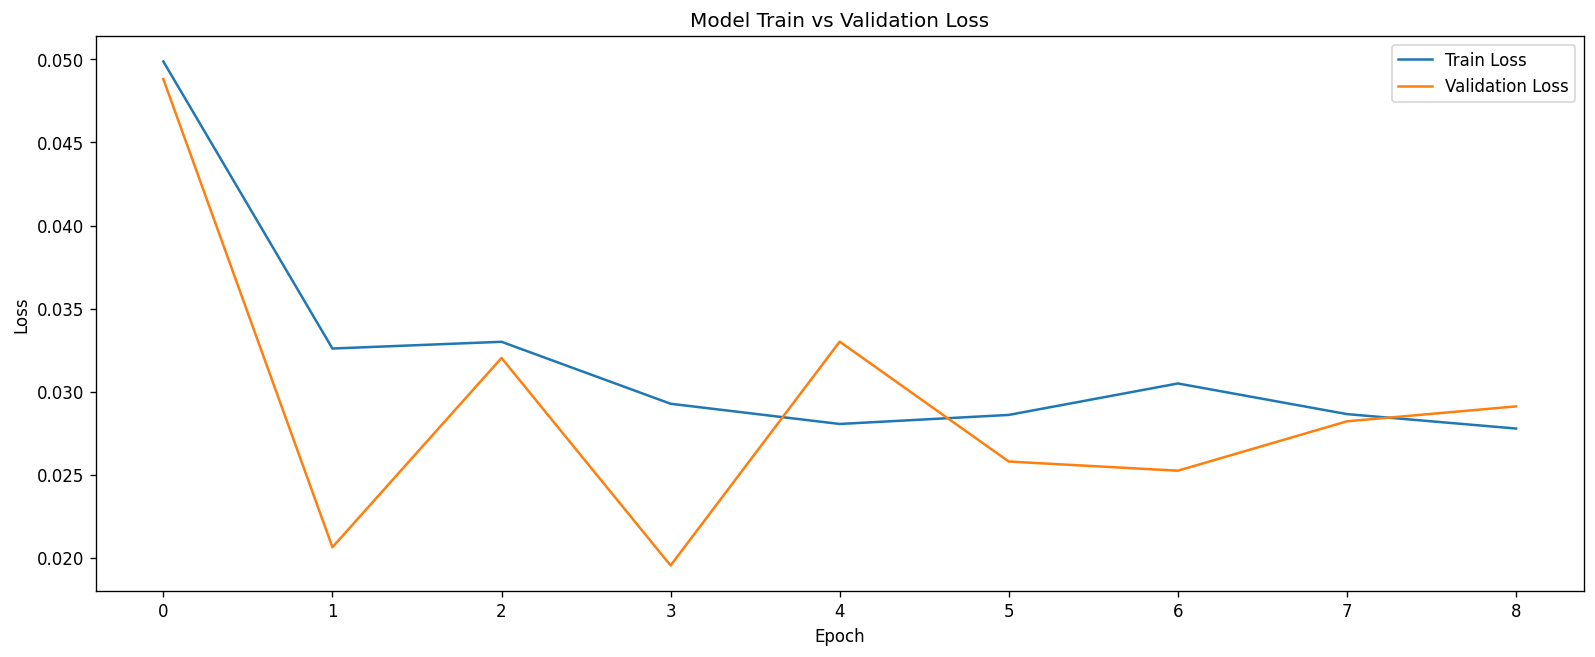

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure(figsize=(16, 6), dpi=120)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Model Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.savefig(os.path.join(output_dir, 'loss_plot.png'))

**Testing**

In [46]:
loaded_model = get_model(model_name)
loaded_model.load_state_dict(torch.load(f"{output_dir}/best_model.pth", map_location=device))
loaded_model.to(device).eval()

AutoencoderLSTM(
  (encoder): LSTM(1, 4, batch_first=True)
  (decoder): Linear(in_features=4, out_features=1, bias=True)
)

In [47]:
with torch.no_grad():
    X_train_pred = model(X_train.to(device))
X_train_pred = X_train_pred.to('cpu')

mse = F.mse_loss(X_train_pred, X_train)

# Plot a histogram of computed MSE values for training data
plt.hist(mse.view(-1).detach().numpy(), bins=50, color='purple', edgecolor='purple', alpha=0.4, histtype='bar')  # Convert to NumPy array for plotting
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Squared Error')
plt.show()

/tmp/ipykernel_221817/3479356668.py:5: UserWarning: Using a target size (torch.Size([6973, 30, 1])) that is different to the input size (torch.Size([6973, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(X_train_pred, X_train)


RuntimeError: The size of tensor a (6973) must match the size of tensor b (30) at non-singleton dimension 1